# Informe: Predicción de éxitos en oportunidades comerciales

## 1. Exploración de datos

En esta sección se muestran las principales características detectadas en los datos que sirvieron para agregar información a los modelos hechos.  
En principio quedémonos con los datos de las oportunidades que terminaron en failure o success (o sea, "Closed Lost" o Closed Won"). El dato que parece determinante en una oportunidad es *Sales_Contract_No*, o mejor dicho, si la oportunidad tiene definido un número de contrato.

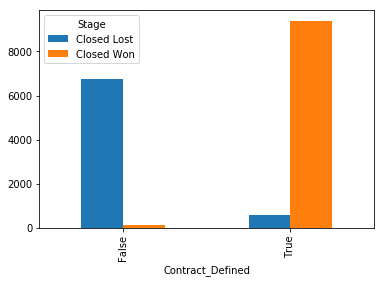

In [5]:
import pandas as pd
data = pd.read_csv("Entrenamieto_ECI_2020.csv")
data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
data["Contract_Defined"] = data.Sales_Contract_No != "None"
pd.crosstab(data.Contract_Defined, data.Stage).plot(kind='bar')

Como se ve, si hay contrato cerrado la probabilidad de cerrar la negociación es muy alta. De la misma manera, si no hay número de contrato definido probablemente se convierta en "Closed Lost".  
Otros datos que parecen interesantes para analizar son las fechas. Veamos por ejemplo que pasa con el tiempo (en días) que toma el delivery planificado del producto.

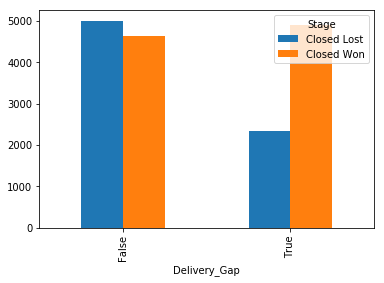

In [16]:
data["Planned_Delivery_Start_Date"] = pd.to_datetime(data.Planned_Delivery_Start_Date)
data["Planned_Delivery_End_Date"] = pd.to_datetime(data.Planned_Delivery_End_Date)
data["Delivery_Gap"] = (data.Planned_Delivery_End_Date - data.Planned_Delivery_Start_Date).dt.days == 0
pd.crosstab(data.Delivery_Gap, data.Stage).plot(kind='bar')

El gráfico muestra si el delivery planificado se concreta el mismo día o toma más días. Se puede ver que si toma más días no se puede diferenciar si la oportunidad va a terminar en success. De lo contrario, pareciera que si el delivery planificado es en un mismo día la chances de success de una oportunidad casi que duplican las de failure.  
Otra relación que parece importante es la noción del tiempo que tomó el contacto comercial. Por ejemplo, tomemos la diferencia entre la fecha límite del delivery previsto y la fecha en que se creó la oportunidad comercial.

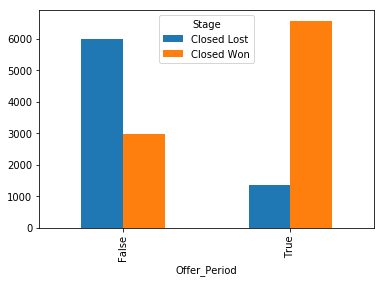

In [18]:
data["Opportunity_Created_Date"] = pd.to_datetime(data.Opportunity_Created_Date)
data["Offer_Period"] = data["Concrete_Offer"] = (data.Planned_Delivery_End_Date - data.Opportunity_Created_Date).dt.days
pd.crosstab(data.Offer_Period <= 60, data.Stage).plot(kind='bar')

En el gráfico se muestra si el contacto fue de menos de 60 días. Es interesante notar que las probabilidades de success son buenas si el contacto no se extiende más de ese plazo. Por otro lado, si se extiende más de 60 días claramente las oportunidades que derivaron en failure son más que success. 
Por último, otra noción que parece ser importante es la cantidad de contactos comerciales que tiene un cliente. Intuitivamente, un cliente que hace varios contactos tendería a comprar el producto. El siguiente gráfico muestra dicha noción:

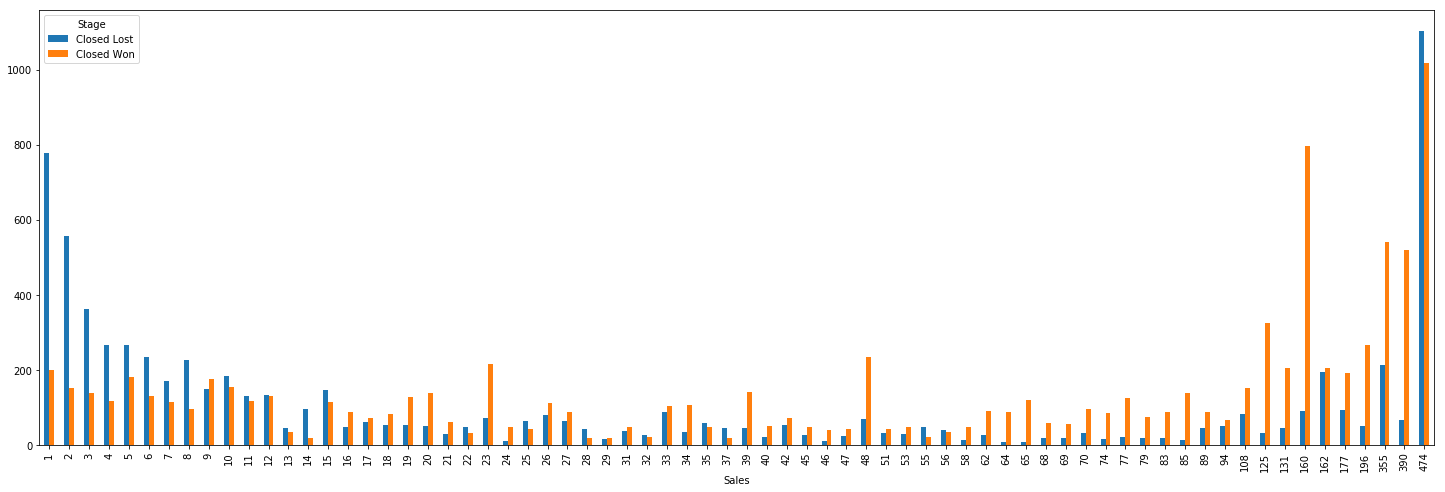

In [41]:
data["Sales"] = data.groupby("Account_Name", sort=False)["Opportunity_ID"].transform(lambda x: x.nunique())
pd.crosstab(data.Sales, data.Stage).plot(kind='bar', figsize=(25, 8))

Se puede observar que con menos contactos los failures predominan. A medida que van aumentando, tienden a terminar más oportunidades en success.

## 2. Feature engineering

Empecemos por las variables que no se usaron:
* *ID* y *Opportunity_ID*
* Las variables que corresponden a fechas. Esto se decidió así porque o bien había columnas que no aportaban datos (como *Actual_Delivery_Date*) o se trasformaron en otras variables para los modelos (como los ejemplos de diferencias de fechas de la sección anterior).
* La variable *Sales_Contract_No* se transformó en otra variable para indicar si estaba definido el número de contrato.
* Las siguientes variables no aportaban información relevante para los modelos: *Opportunity_Name*, *Product_Type*, *Account_Type*, *ASP_converted_Currency*, *Prod_Category_A*, *Product_Category_B*, *Product_Name*,  *Delivery_Year*, *Submitted_for_Approval*, *Delivery_Terms*, *Size*, *Price*, *ASP_Currency*, *Total_Amount_Currency*, *Total_Taxable_Amount_Currency*, *Quote_Type*, *Opportunity_Type*, *Product_Family*, *Account_Name*.
* Las variables *Brand*, *TRF*, *Month* se usaron para crear otras variables.

ACA TARGET LEKEAGE

Variables usadas en los modelos: *Region*, *Territory*, *Pricing, Delivery_Terms_Quote_Appr*, *Pricing, Delivery_Terms_Approved*, *Bureaucratic_Code_0_Approval*, *Bureaucratic_Code_0_Approved*, *Bureaucratic_Code*, *Source*, *Billing_Country*, *Account_Owner*, *Opportunity_Owner*, *Currency*, *Last_Modified_By*, *ASP*, *ASP_(converted)*, *Delivery_Quarter*, *Total_Amount*, *Total_Taxable_Amount*.

Variables agregadas en los modelos:
* Del análisis de datos se decidió agregar las variables explicadas en la sección anterior:
*Contract_Defined*, *Delivery_Gap*, *Offer_Period* (con alguna variante de cantidad de días límite) y *Sales*.  
* Variable que intenta indicar si el contacto comercial se mantuvo con un solo vendedor (si el *Account_Owner* es el mismo que el *Opportunity_Owner*)
* Variable que indica si el producto tiene *Brand* definida.
* Variable que indica si la facturación se produjo en territorio diferente: *Billing_Country* distinto a *Territory*.
* Variable que agrupa valores de *TRF*.
* Variable que indica el mes de los deliveries previstos (se usó *Month*).
* Variable que trata de explicar la duración total del presupuesto.
* Variable que trata de explicar si hubo contacto luego de que venciera el presupuesto de la oportunidad.

## 3. Modelos usados

Dada la naturaleza del problema se decidió usar decision trees para predecir la probabilidad de éxito de las oportunidades. En particular se usaron algoritmos de boosting sobre decision trees:

* CatBoost
* XGBoost
* AdaBoost

Además, se hicieron pruebas combinando los outputs de los modelos promediando las predicciones para cada oportunidad

## 4. Conclusiones

## 5. Trabajo futuro

In [50]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", 
          "Prod_Category_A", "Product_Category_B", "ASP_(converted)_Currency", "Product_Name", 
         "Delivery_Year", "TRF", "Submitted_for_Approval", "Delivery_Terms", "Size",
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [51]:
data.drop(clear + target + dates, axis = 1).columns

Index([u'Region', u'Territory', u'Pricing, Delivery_Terms_Quote_Appr',
       u'Pricing, Delivery_Terms_Approved', u'Bureaucratic_Code_0_Approval',
       u'Bureaucratic_Code_0_Approved', u'Bureaucratic_Code', u'Source ',
       u'Billing_Country', u'Account_Owner', u'Opportunity_Owner',
       u'Account_Type', u'Currency', u'Last_Modified_By', u'ASP',
       u'ASP_(converted)', u'Month', u'Delivery_Quarter', u'Total_Amount',
       u'Total_Taxable_Amount', u'Contract_Defined', u'Contacts',
       u'Delivery_Gap', u'Offer_Period', u'Concrete_Offer', u'Sales'],
      dtype='object')

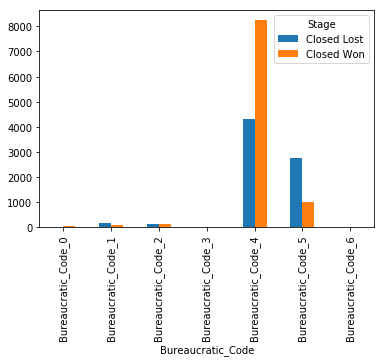

In [55]:
pd.crosstab(data.Bureaucratic_Code, data.Stage).plot(kind='bar')